In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add, Dropout
from tensorflow.keras.models import Model
from google.colab import drive

In [ ]:
!git clone https://gitlab.com/skqhddl7/opensourceproject.git
!unzip opensourceproject/images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: images/yangpyeong_M/┼я.png  
  inflating: images/yangpyeong_M/┼Ё.png  
  inflating: images/yangpyeong_M/┼ё.png  
 extracting: images/yangpyeong_M/┼Є.png  
 extracting: images/yangpyeong_M/┼є.png  
  inflating: images/yangpyeong_M/┼Ї.png  
  inflating: images/yangpyeong_M/┼ї.png  
  inflating: images/yangpyeong_M/┼Ў.png  
  inflating: images/yangpyeong_M/┼ў.png  
 extracting: images/yangpyeong_M/┼°.png  
 extracting: images/yangpyeong_M/┼∙.png  
 extracting: images/yangpyeong_M/┼·.png  
 extracting: images/yangpyeong_M/┼√.png  
 extracting: images/yangpyeong_M/┼№.png  
  inflating: images/yangpyeong_M/┼¤.png  
 extracting: images/yangpyeong_M/┼■.png  
  inflating: images/yangpyeong_M/╞б.png  
  inflating: images/yangpyeong_M/╞в.png  
  inflating: images/yangpyeong_M/╞г.png  
 extracting: images/yangpyeong_M/╞д.png  
 extracting: images/yangpyeong_M/╞е.png  
  inflating: images/yangpyeong_M/╞ж.png  
 extracting: images/yangpyeong_M/╞з.png 

In [ ]:
data_dir = '/content/images'

batch_size = 32
img_height = 32
img_width = 32

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 664252 files belonging to 285 classes.
Using 597827 files for training.
Found 664252 files belonging to 285 classes.
Using 66425 files for validation.


In [ ]:
train_batches = tf.data.experimental.cardinality(train_ds)
test_ds = train_ds.take(train_batches // 9)
train_ds = train_ds.skip(train_batches // 9)

print('Number of train batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of train batches: 16608
Number of validation batches: 2076
Number of test batches: 2075


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

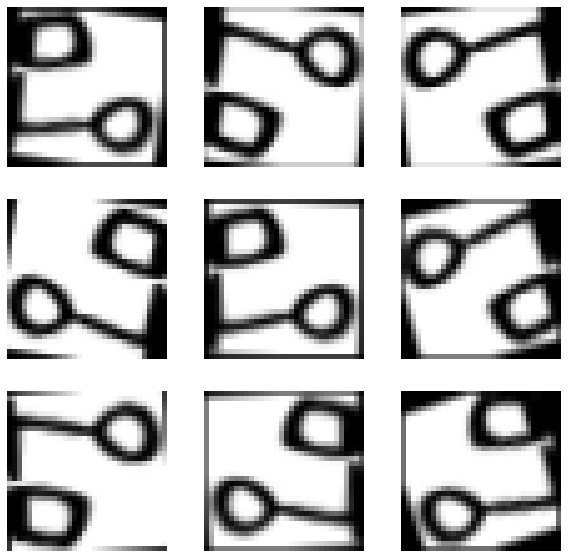

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.05, fill_mode="constant", fill_value=1.0),
    layers.experimental.preprocessing.RandomZoom(0.05, fill_mode="constant", fill_value=1.0),
  ]
)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=INIT_SCHEME)
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.data_aug = data_augmentation
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(3, 3), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.do = Dropout(.2)
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.data_aug(inputs)
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.do(out)
        out = self.fc(out)
        return out

In [ ]:
num_classes = 285

model = ResNet18(num_classes)
model.build(input_shape = (None,32,32,3))

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple                 74

In [ ]:
epochs = 15

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
16608/16608 [==============================] - 1055s 60ms/step - loss: 1.5482 - accuracy: 0.5492 - val_loss: 0.8607 - val_accuracy: 0.7382
Epoch 2/15
16608/16608 [==============================] - 1010s 59ms/step - loss: 0.6244 - accuracy: 0.8002 - val_loss: 0.5108 - val_accuracy: 0.8403
Epoch 3/15
16608/16608 [==============================] - 1013s 59ms/step - loss: 0.4555 - accuracy: 0.8554 - val_loss: 0.3420 - val_accuracy: 0.8917
Epoch 4/15
16608/16608 [==============================] - 1008s 59ms/step - loss: 0.3767 - accuracy: 0.8824 - val_loss: 0.2669 - val_accuracy: 0.9141
Epoch 5/15
16608/16608 [==============================] - 1003s 59ms/step - loss: 0.3313 - accuracy: 0.8983 - val_loss: 0.2140 - val_accuracy: 0.9311
Epoch 6/15
16608/16608 [==============================] - 1004s 59ms/step - loss: 0.3015 - accuracy: 0.9089 - val_loss: 0.2618 - val_accuracy: 0.9251
Epoch 7/15
16608/16608 [==============================] - 1006s 59ms/step - loss: 0.2801 - accuracy:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)